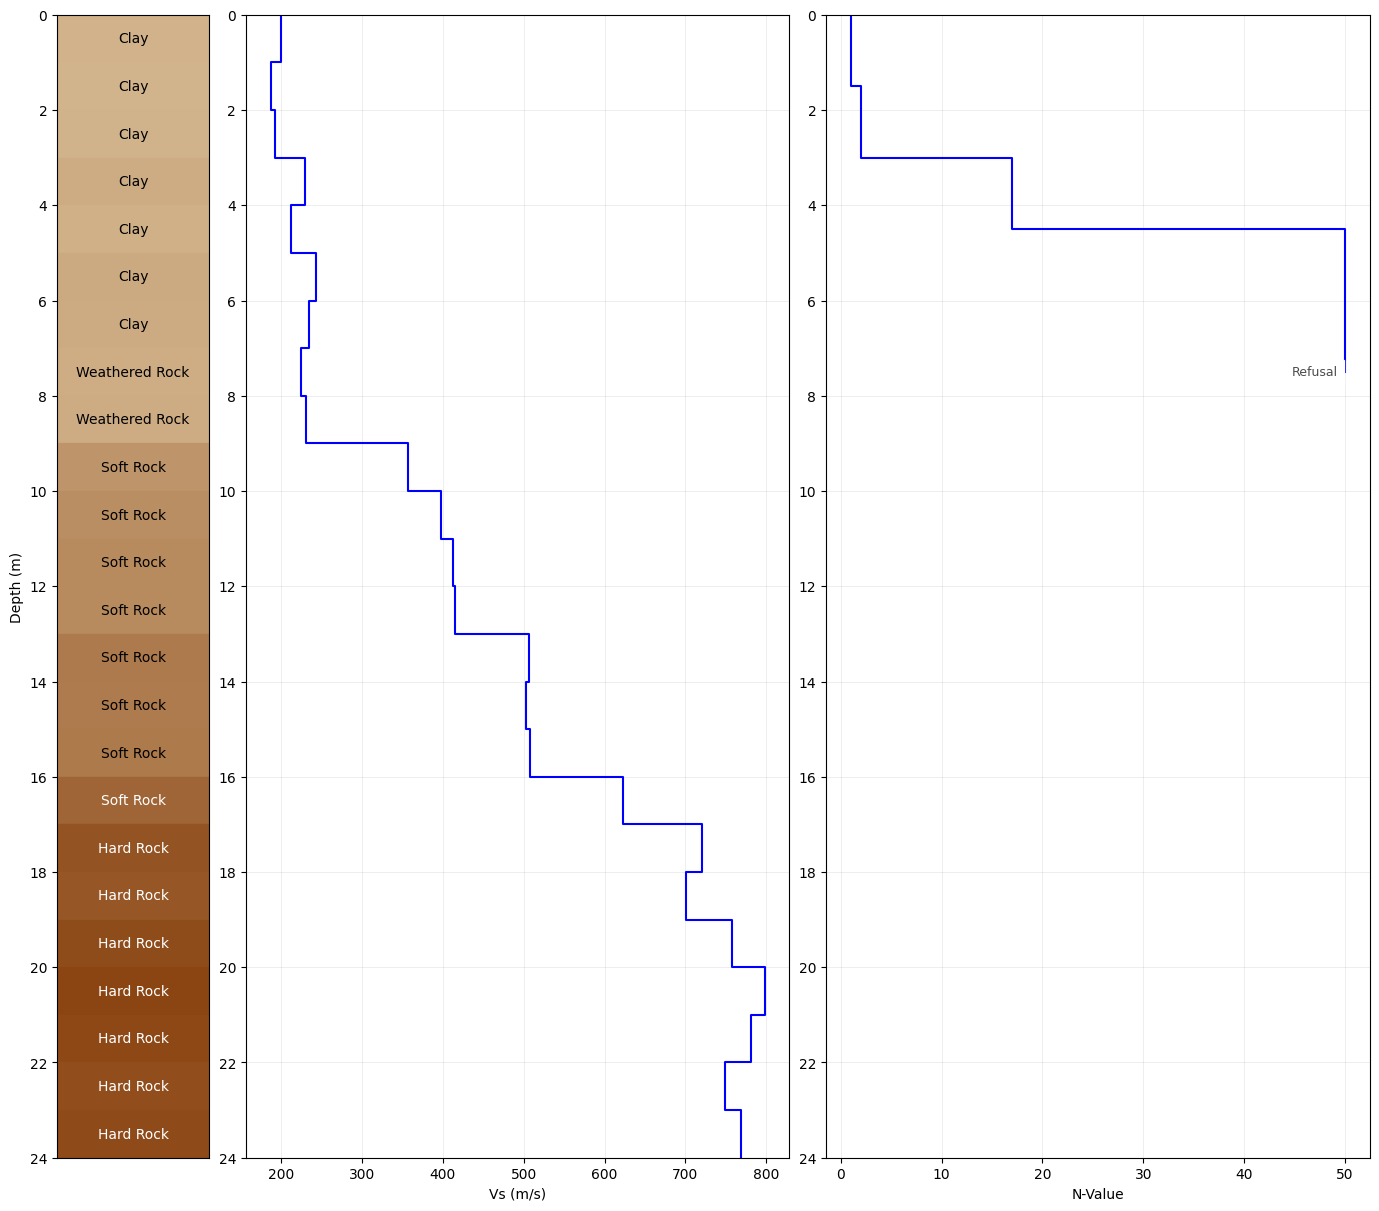

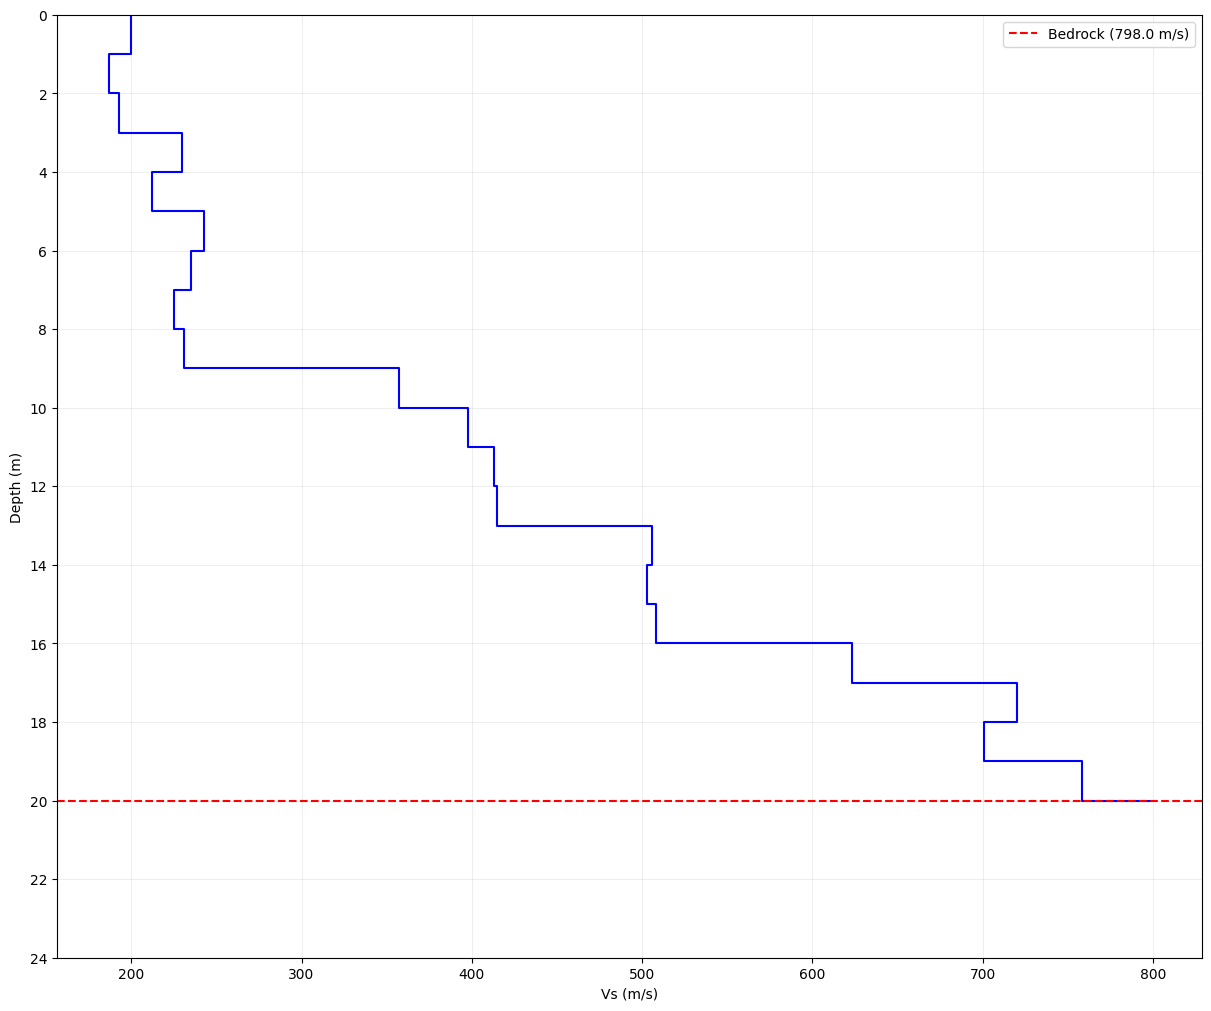

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import csv
from io import StringIO
from collections import OrderedDict

# ─── Replace this with your actual CSV text or filename ───
csv_content = """Layer,Classification,Depth_vs,Vs,Depth_n,N
Layer 1,Clay,0,200,0,1
Layer 1,Clay,1,200,1.5,1
Layer 2,Clay,1,187,1.5,2
Layer 2,Clay,2,187,3,2
Layer 3,Clay,2,193,3,17
Layer 3,Clay,3,193,4.5,17
Layer 4,Clay,3,230,4.5,50
Layer 4,Clay,4,230,7.5,50
Layer 5,Clay,4,212,,
Layer 5,Clay,5,212,,
Layer 6,Clay,5,243,,
Layer 6,Clay,6,243,,
Layer 7,Clay,6,235,,
Layer 7,Clay,7,235,,
Layer 8,Weathered Rock,7,225,,
Layer 8,Weathered Rock,8,225,,
Layer 9,Weathered Rock,8,231,,
Layer 9,Weathered Rock,9,231,,
Layer 10,Soft Rock,9,357,,
Layer 10,Soft Rock,10,357,,
Layer 11,Soft Rock,10,398,,
Layer 11,Soft Rock,11,398,,
Layer 12,Soft Rock,11,413,,
Layer 12,Soft Rock,12,413,,
Layer 13,Soft Rock,12,415,,
Layer 13,Soft Rock,13,415,,
Layer 14,Soft Rock,13,506,,
Layer 14,Soft Rock,14,506,,
Layer 15,Soft Rock,14,503,,
Layer 15,Soft Rock,15,503,,
Layer 16,Soft Rock,15,508,,
Layer 16,Soft Rock,16,508,,
Layer 17,Soft Rock,16,623,,
Layer 17,Soft Rock,17,623,,
Layer 18,Hard Rock,17,720,,
Layer 18,Hard Rock,18,720,,
Layer 19,Hard Rock,18,701,,
Layer 19,Hard Rock,19,701,,
Layer 20,Hard Rock,19,758,,
Layer 20,Hard Rock,20,758,,
Layer 21,Hard Rock,20,798,,
Layer 21,Hard Rock,21,798,,
Layer 22,Hard Rock,21,781,,
Layer 22,Hard Rock,22,781,,
Layer 23,Hard Rock,22,749,,
Layer 23,Hard Rock,23,749,,
Layer 24,Hard Rock,23,769,,
Layer 24,Hard Rock,24,769,,
"""

def get_contrast_text_color(rgb):
    b = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    return "white" if b < 0.5 else "black"

def plot_layer_classification(ax, boundaries, labels, vs_vals):
    norm = mcolors.Normalize(min(vs_vals), max(vs_vals))
    cmap = LinearSegmentedColormap.from_list("brown_shades", ["#d2b48c", "#8B4513"])
    for (top, bot), cls, vs in zip(boundaries, labels, vs_vals):
        color = cmap(norm(vs))
        ax.fill_betweenx([top, bot], 0, 1, color=color)
        mid = (top + bot) / 2
        ax.text(0.5, mid, cls,
                ha='center', va='center',
                color=get_contrast_text_color(color),
                fontsize=10)
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_ylabel("Depth (m)")

def plot_shearwave_velocity(ax, depth, vs):
    ax.step(vs, depth, where='post', color='blue')
    ax.set_xlabel("Vs (m/s)")
    ax.grid(True, linewidth=0.5, alpha=0.3)

def plot_n_values(ax, depth, nvals):
    ax.step(nvals, depth, where='post', color='blue')
    ax.set_xlabel("N-Value")
    ax.grid(True, linewidth=0.5, alpha=0.3)
    xmin, xmax = ax.get_xlim()
    # annotate only the 2nd and 6th N>=50 inside the plot area
    idx = 0
    for d, n in zip(depth, nvals):
        if n >= 50:
            idx += 1
            if idx in (2, 6):
                # place at 90% of x-range to avoid overlap
                x_text = xmin + 0.9*(xmax - xmin)
                ax.text(x_text, d, "Refusal", va='center', ha='center',
                        fontsize=9, backgroundcolor='white', alpha=0.7)

def truncate_profile(depth, vs, cutoff):
    d2, v2 = [], []
    for d, v in zip(depth, vs):
        if d <= cutoff:
            d2.append(d); v2.append(v)
        else:
            break
    return d2, v2

def main():
    # Read CSV
    f = StringIO(csv_content)
    reader = csv.DictReader(f)
    rows = [r for r in reader if r["Layer"] and not r["Layer"].startswith("#")]

    # Vs series
    depth_vs_all = [float(r["Depth_vs"]) for r in rows]
    vs_all       = [float(r["Vs"])        for r in rows]

    # N series (skip blanks)
    depth_n_all, n_all = [], []
    for r in rows:
        dn, nn = r["Depth_n"].strip(), r["N"].strip()
        if dn and nn:
            depth_n_all.append(float(dn))
            n_all.append(float(nn))

    # Group by layer to get intervals & Vs per layer
    groups = OrderedDict()
    for r in rows:
        L = r["Layer"]
        if L not in groups:
            groups[L] = {"classification": r["Classification"],
                         "depth_vs": [], "vs": []}
        groups[L]["depth_vs"].append(float(r["Depth_vs"]))
        groups[L]["vs"].append(float(r["Vs"]))

    # Build boundaries, labels, Vs-values
    layer_boundaries = []
    layer_vs_values  = []
    layer_classifs   = []
    for g in groups.values():
        dv = sorted(g["depth_vs"])
        top, bot = dv[0], dv[-1]
        layer_boundaries.append((top, bot))
        layer_vs_values.append(g["vs"][0])
        layer_classifs.append(g["classification"])

    # Determine overall depth range & ticks
    overall_top    = layer_boundaries[0][0]
    overall_bottom = layer_boundaries[-1][1]
    yticks = np.arange(overall_top, overall_bottom + 1, 2)

    # Find max label length to size classification axis
    max_label_len = max(len(lbl) for lbl in layer_classifs)
    char_width = 0.12               # inches per character estimate
    class_width = max_label_len * char_width
    other_width = 6                 # inches for each of the other plots

    # Engineering bedrock detection
    max_vs       = max(vs_all)
    max_vs_depth = depth_vs_all[vs_all.index(max_vs)]
    eng_bedrock  = next((t for t, b in layer_boundaries if t <= max_vs_depth < b), None)

    # Figure 1: classification + Vs (+ N if available)
    if depth_n_all:
        total_width = class_width + 2*other_width
        fig = plt.figure(figsize=(total_width, 12), constrained_layout=True)
        gs = fig.add_gridspec(1, 3, width_ratios=[class_width, other_width, other_width])
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[0,1])
        ax3 = fig.add_subplot(gs[0,2])
    else:
        total_width = class_width + other_width
        fig = plt.figure(figsize=(total_width, 12), constrained_layout=True)
        gs = fig.add_gridspec(1, 2, width_ratios=[class_width, other_width])
        ax1 = fig.add_subplot(gs[0,0])
        ax2 = fig.add_subplot(gs[0,1])
        ax3 = None

    plot_layer_classification(ax1, layer_boundaries, layer_classifs, layer_vs_values)
    plot_shearwave_velocity   (ax2, depth_vs_all, vs_all)
    if ax3:
        plot_n_values(ax3, depth_n_all, n_all)

    # Apply uniform y-axis to all subplots
    for ax in [ax1, ax2] + ([ax3] if ax3 else []):
        ax.set_ylim(overall_bottom, overall_top)
        ax.set_yticks(yticks)

    plt.show()

    # Figure 2: Vs truncated at bedrock
    if eng_bedrock is not None:
        td, tv = truncate_profile(depth_vs_all, vs_all, eng_bedrock)
    else:
        td, tv = depth_vs_all, vs_all

    fig2, ax4 = plt.subplots(figsize=(12, 10), constrained_layout=True)
    plot_shearwave_velocity(ax4, td, tv)
    ax4.set_ylabel("Depth (m)")
    ax4.set_ylim(overall_bottom, overall_top)
    ax4.set_yticks(yticks)
    if eng_bedrock is not None:
        ax4.axhline(eng_bedrock, color='red', linestyle='--',
                    label=f"Bedrock ({max_vs:.1f} m/s)")
        ax4.legend()
    plt.show()

if __name__ == "__main__":
    main()
